In [10]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [11]:
file_name = '../measurements_python.csv'        
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
print(df.describe())

       PowerLimit      Package           Core           Time  Temperature  \
count  599.000000   599.000000     599.000000     599.000000   599.000000   
mean    34.816361   622.119496      70.324342   43396.327212    49.235392   
std     39.477774   859.966168   10628.125208   71635.958929     6.366156   
min     -1.000000    90.024170 -259030.248047   11008.000000    37.000000   
25%      5.000000   260.181091     160.674530   15267.000000    44.100000   
50%     10.000000   320.574463     282.252319   18307.000000    51.600000   
75%     45.000000   475.513214     419.726105   30913.000000    54.300000   
max    115.000000  3804.868530    3331.643921  432469.000000    59.200000   

              Memory  
count     599.000000  
mean    52296.080134  
std     18556.019131  
min     43336.000000  
25%     43624.000000  
50%     43768.000000  
75%     43952.000000  
max    102332.000000  


#### Comparar PowerLimit e Package só do avrora

<Axes: xlabel='PowerLimit', ylabel='Package'>

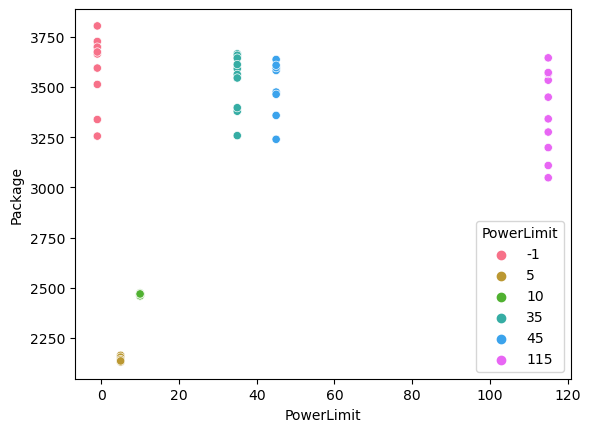

In [12]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
program_df = df[df['Program'] == ' docutils']

custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=program_df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df


#### Comparar PowerLimit e Package de todos

<Axes: xlabel='PowerLimit', ylabel='Package'>

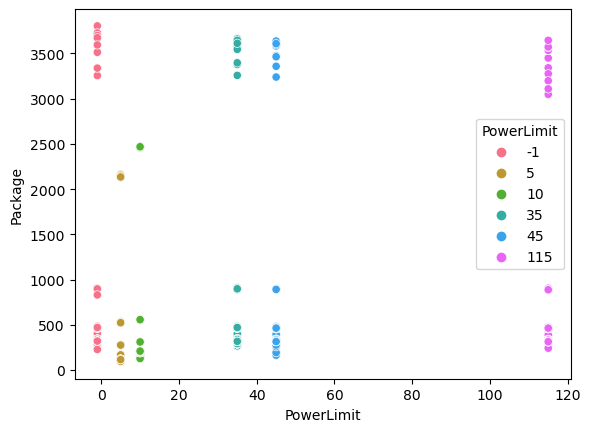

In [13]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df

#### Box Plots para todos os benchmarks

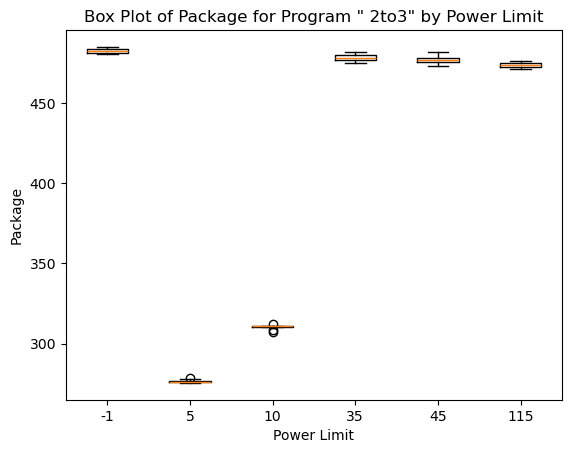

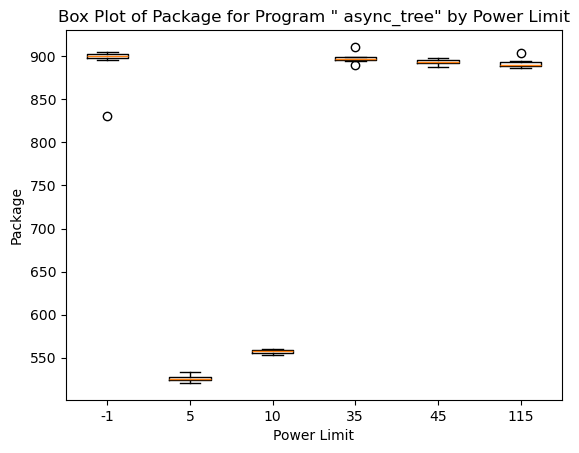

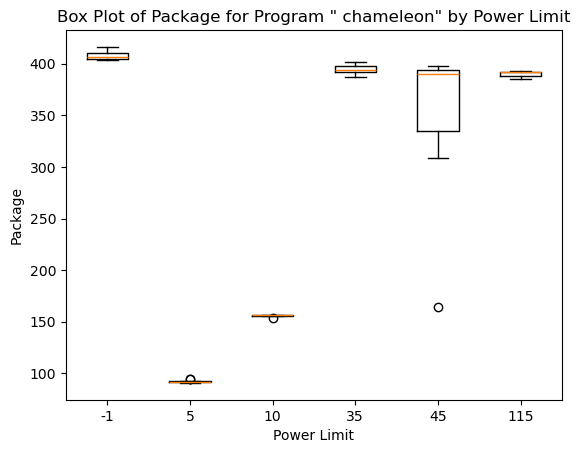

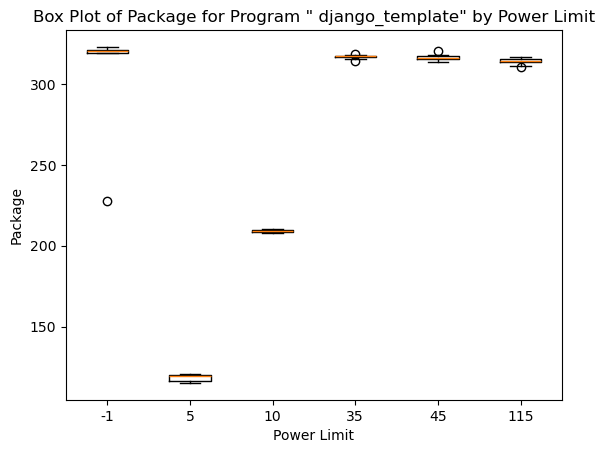

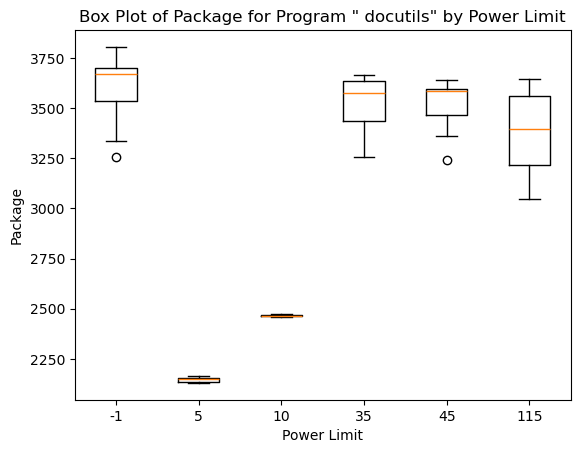

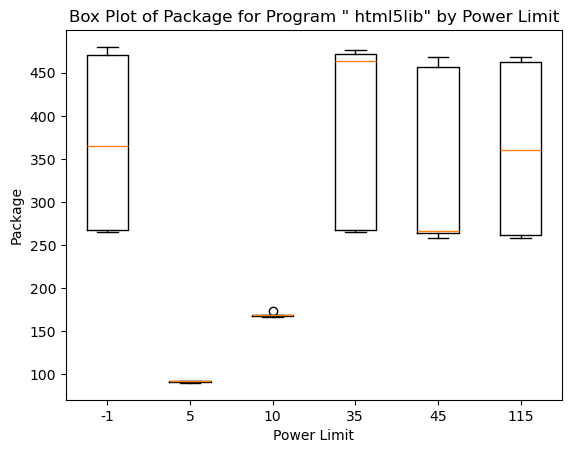

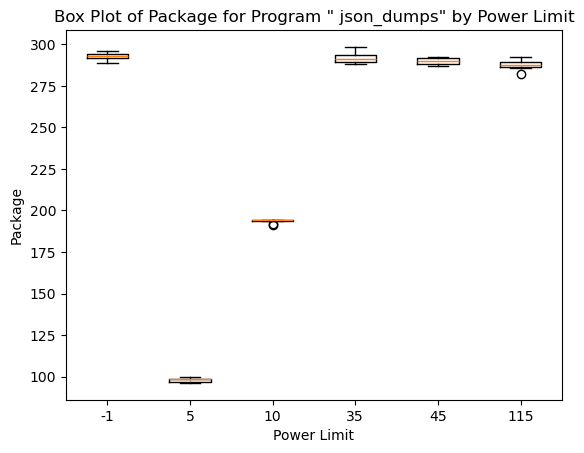

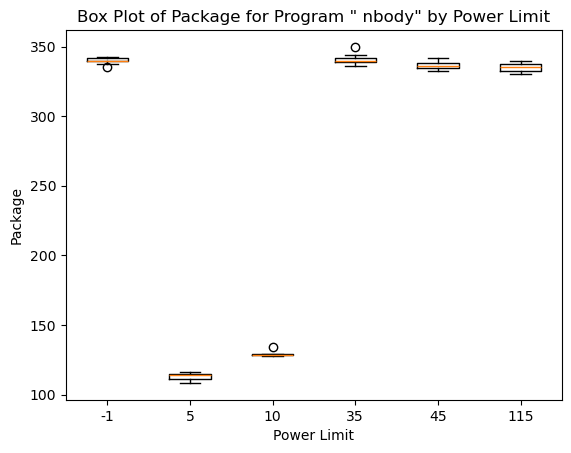

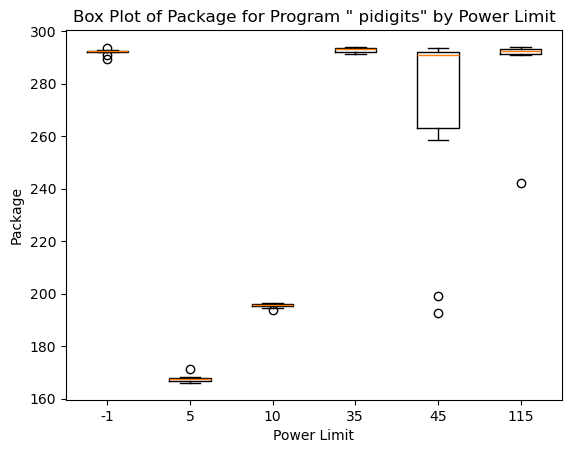

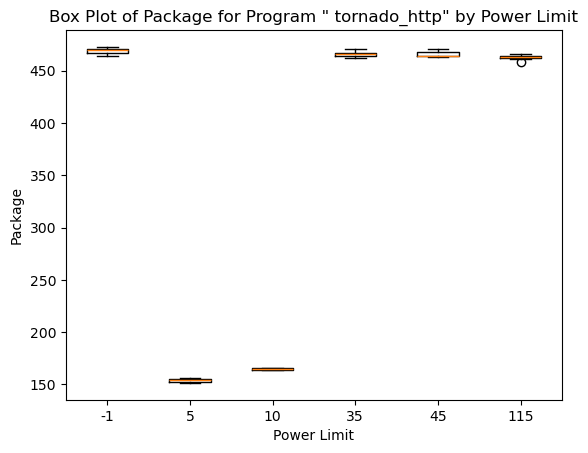

In [14]:
# Iterate over each program group
groups = df.groupby('Program')
def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Package'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Package')
        plt.title(f'Box Plot of Package for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [15]:
grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
#groups = cleaned_df.groupby('Program')
#show_box_plot(groups)

#### Density Estimation

<Axes: xlabel='Package', ylabel='Count'>

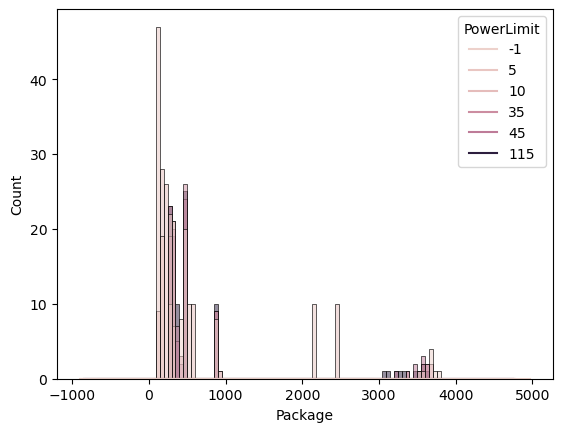

In [16]:
sea.histplot(data=cleaned_df, hue='PowerLimit', x='Package')
sea.kdeplot(data=cleaned_df, hue='PowerLimit', x='Package')

## Correlação entre Variáveis

##### real_gg (sem powercap -1, se não o gráfico fica errado)

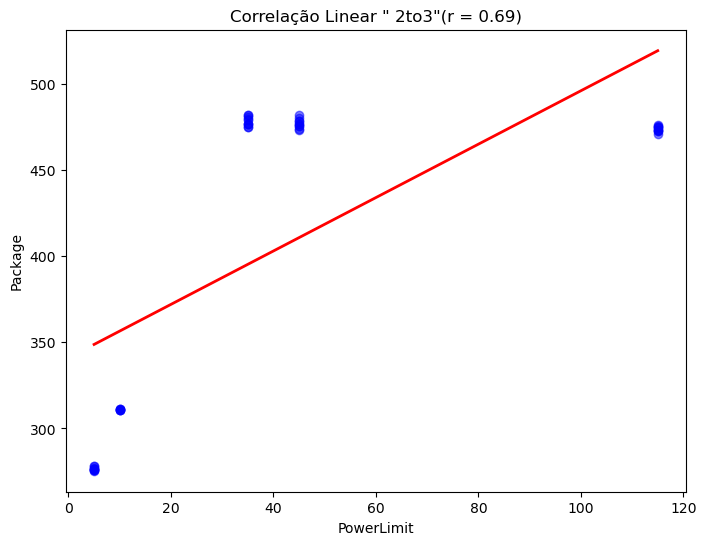

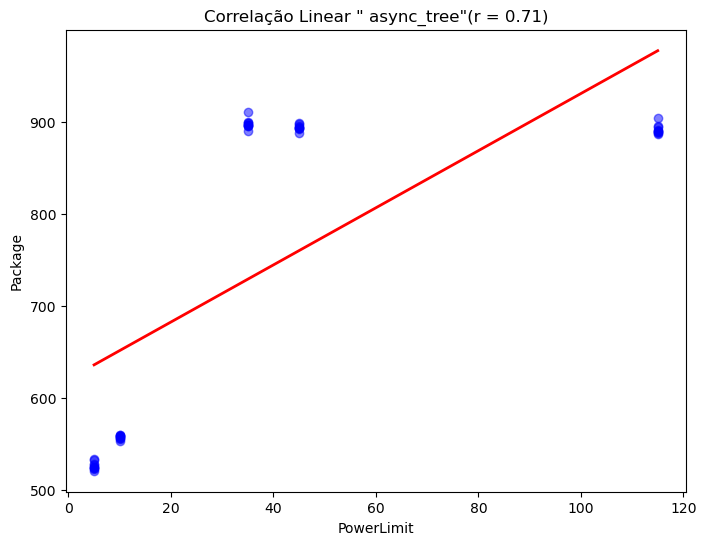

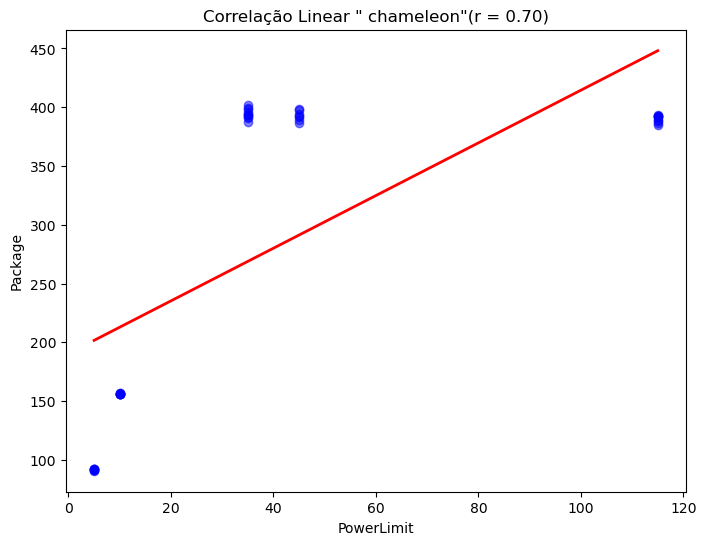

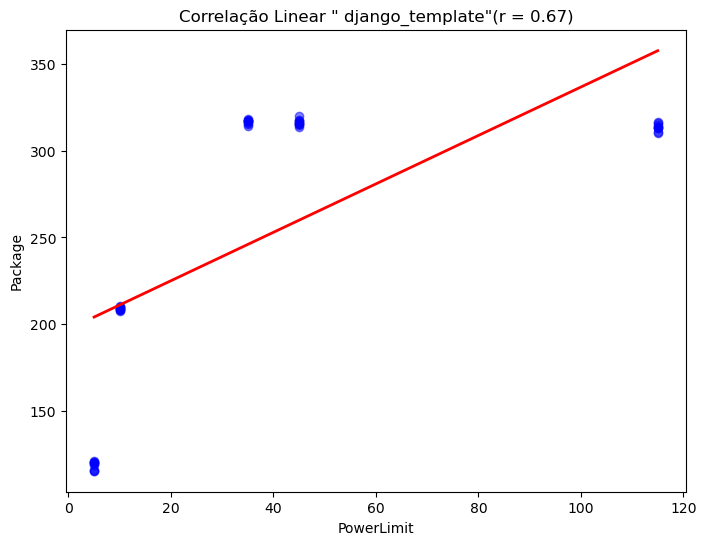

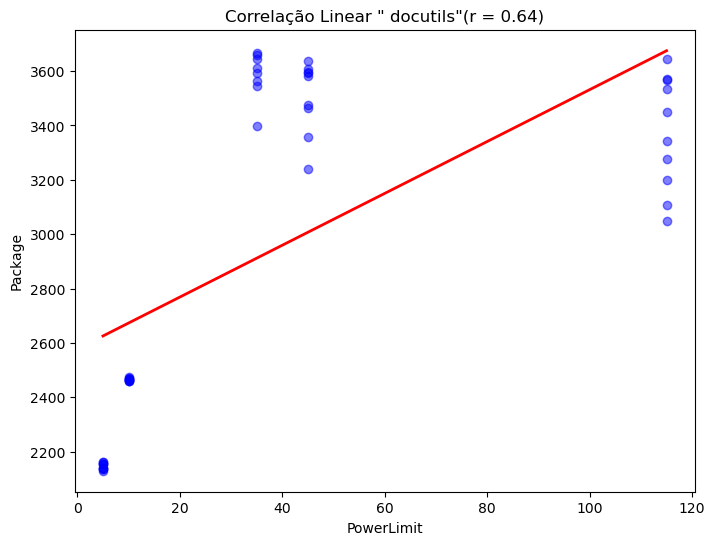

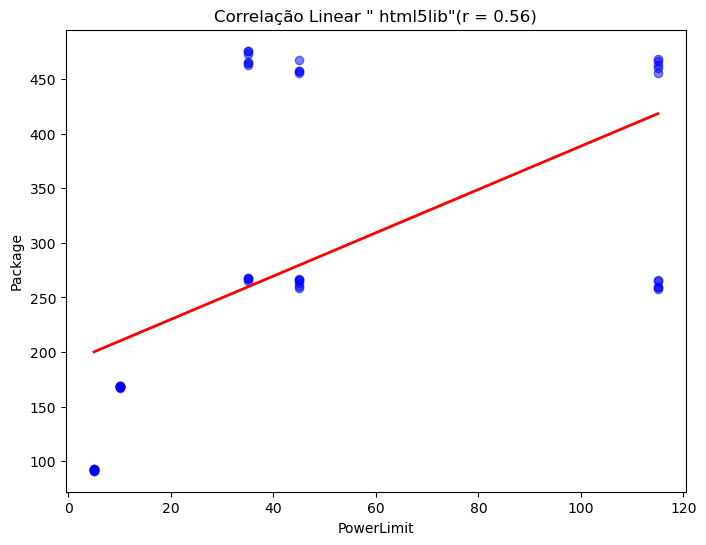

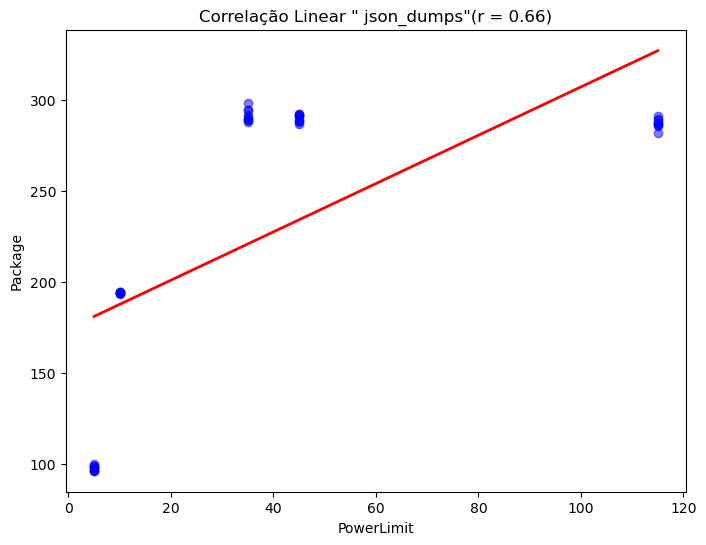

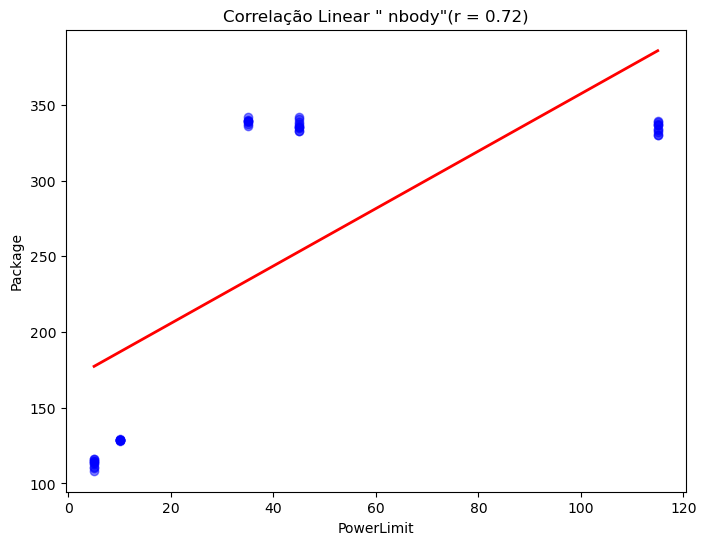

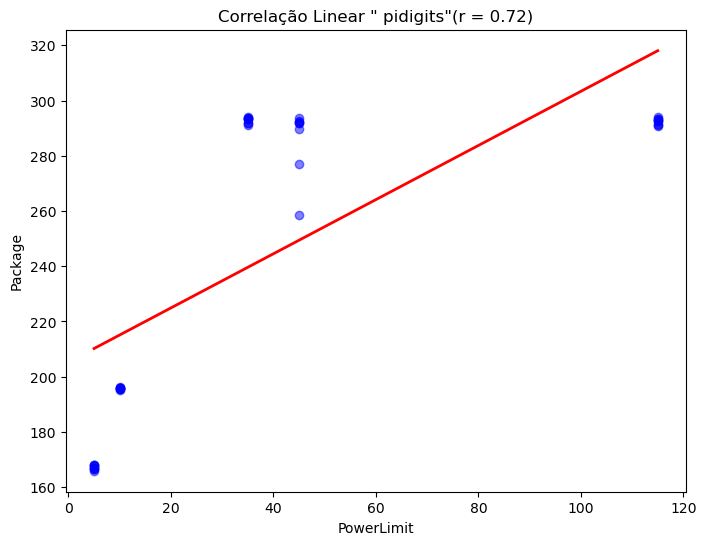

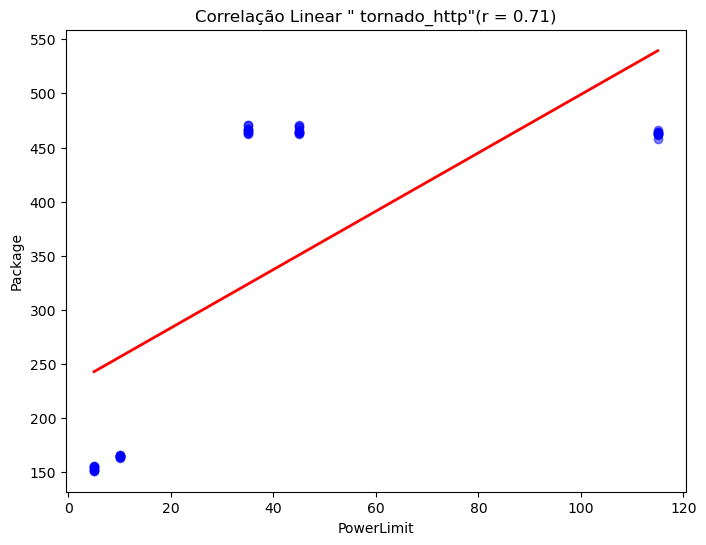

In [17]:
#file_nameh1 = 'measurements_haskell.csv'        
#dfh1 = pd.read_csv(file_nameh1, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
cleaned_df2 = cleaned_df
dfh1 = cleaned_df2[cleaned_df2['PowerLimit'] != -1]
groups = dfh1.groupby('Program')


def show_corr_linear(groups):
    for name, program_group in groups:

        

        # Criando o gráfico de dispersão
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Package'], color='blue', alpha=0.5)

        # Adicionando a linha de regressão linear
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Package'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Package')
        plt.title(f'Correlação Linear "{name}"(r = '+'{:.2f})'.format(r_value))
        plt.show()


show_corr_linear(groups)


### Teste de 1. **Pearson**

In [18]:
def calculate_correlations(group):
    # 1. **Pearson** correlation
    Pearson_corr, Pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # **Spearman** correlation
    Spearman_corr, Spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # 3. **Kendall** Tau correlation
    Kendall_corr, Kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [Pearson_corr],
        'Pearson_p': [Pearson_p],
        'Spearman': [Spearman_corr],
        'Spearman_p': [Spearman_p],
        'Kendall': [Kendall_corr],
        'Kendall_p': [Kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

            Program   Pearson     Pearson_p  Spearman    Spearman_p   Kendall  \
0              2to3 -0.616118  4.021078e-06 -0.582304  1.756540e-05 -0.405552   
1        async_tree -0.595957  6.245252e-06 -0.700943  2.044407e-08 -0.520680   
2         chameleon  0.275636  7.014252e-02 -0.103298  5.046041e-01 -0.005855   
3   django_template -0.698508  2.399410e-08 -0.715324  7.679740e-09 -0.540913   
4          docutils -0.563111  3.778848e-05 -0.711272  2.103589e-08 -0.536641   
5          html5lib -0.195458  1.830698e-01 -0.008254  9.555986e-01 -0.018649   
6        json_dumps -0.711190  4.373119e-08 -0.655419  1.029029e-06 -0.464190   
7             nbody -0.302152  3.899960e-02 -0.193715  1.920014e-01 -0.068648   
8          pidigits -0.616709  1.063978e-05 -0.698535  1.903500e-07 -0.529961   
9      tornado_http -0.401643  3.839756e-03 -0.048020  7.405291e-01  0.095772   

      Kendall_p  
0  2.084105e-04  
1  1.086152e-06  
2  9.587026e-01  
3  4.174748e-07  
4  8.804632e-07  


### Correlation Analysis between `PowerLimit` && `Package`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was applied

### Program: 2to3

1. **Pearson**: -0.616118, p-value = 4.021078e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.582304, p-value = 1.756540e-05
    - Moderate negative monotonic relationship, statistically significant.
3. **Kendall**: -0.405552, p-value = 2.084105e-04
    - Moderate negative association, statistically significant.

### Program: async_tree

1. **Pearson**: -0.595957, p-value = 6.245252e-06
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.700943, p-value = 2.044407e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.520680, p-value = 1.086152e-06
    - Moderate negative association, statistically significant.

### Program: chameleon

1. **Pearson**: 0.275636, p-value = 7.014252e-02
    - Weak positive linear relationship, not statistically significant.
2. **Spearman**: -0.103298, p-value = 5.046041e-01
    - Very weak negative monotonic relationship, not statistically significant.
3. **Kendall**: -0.005855, p-value = 9.587026e-01
    - Very weak negative association, not statistically significant.

### Program: django_template

1. **Pearson**: -0.698508, p-value = 2.399410e-08
    - Strong negative linear relationship, statistically significant.
2. **Spearman**: -0.715324, p-value = 7.679740e-09
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.540913, p-value = 4.174748e-07
    - Moderate negative association, statistically significant.

### Program: docutils

1. **Pearson**: -0.560357, p-value = 3.445283e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.699683, p-value = 3.141266e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.526158, p-value = 1.093221e-06
    - Moderate negative association, statistically significant.

### Program: html5lib

1. **Pearson**: -0.195458, p-value = 1.830698e-01
    - Weak negative linear relationship, not statistically significant.
2. **Spearman**: -0.008254, p-value = 9.555986e-01
    - Very weak negative monotonic relationship, not statistically significant.
3. **Kendall**: -0.018649, p-value = 8.628594e-01
    - Very weak negative association, not statistically significant.

### Program: json_dumps

1. **Pearson**: -0.711190, p-value = 4.373119e-08
    - Strong negative linear relationship, statistically significant.
2. **Spearman**: -0.655419, p-value = 1.029029e-06
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.464190, p-value = 3.270944e-05
    - Moderate negative association, statistically significant.

### Program: nbody

1. **Pearson**: -0.302152, p-value = 3.899960e-02
    - Weak negative linear relationship, statistically significant.
2. **Spearman**: -0.193715, p-value = 1.920014e-01
    - Weak negative monotonic relationship, not statistically significant.
3. **Kendall**: -0.068648, p-value = 5.295613e-01
    - Weak negative association, not statistically significant.

### Program: pidigits

1. **Pearson**: -0.616709, p-value = 1.063978e-05
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.698535, p-value = 1.903500e-07
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.529961, p-value = 3.894196e-06
    - Moderate negative association, statistically significant.

### Program: tornado_http

1. **Pearson**: -0.401643, p-value = 3.839756e-03
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.048020, p-value = 7.405291e-01
    - Very weak negative monotonic relationship, not statistically significant.
3. **Kendall**: 0.095772, p-value = 3.645534e-01
    - Weak positive association, not statistically significant.



## Conclusion

When the Powerlimit grows the Package increases in each benchmark, proven throughout this notebook. 

This proves the initial hypothesis that Powercap caps the resource usage which makes us conclude that the lower the value in the Powerlimit the higher the power limitation.